In [9]:
# Uvoz potrebnih biblioteka
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from graphs import plot_grade_distribution_and_boundaries, categorize_attendance
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans



# Postavljanje lepšeg prikaza grafika u notebook-u
%matplotlib inline

# Učitavanje dataset-a
af_data = pd.read_csv('datasets/afrikaNovi.csv')
ir_data = pd.read_csv('datasets/irak.csv')
pk_data = pd.read_csv('datasets/pakistan.csv')
pr_data = pd.read_csv('datasets/Portuguese.csv')

# Brza provera prvih par redova svakog dataset-a
af_data.head()


,Timestamp,Your Sex?,Your Matric (grade 12) Average/ GPA (in %),What year were you in last year (2023) ?,What faculty does your degree fall under?,Your 2023 academic year average/GPA in % (Ignore if you are 2024 1st year student),Your Accommodation Status Last Year (2023),Monthly Allowance in 2023,Were you on scholarship/bursary in 2023?,Additional amount of studying (in hrs) per week,...,"How many classes do you miss per week due to alcohol reasons, (i.e: being hungover or too tired?)",How many modules have you failed thus far into your studies?,Are you currently in a romantic relationship?,Do your parents approve alcohol consumption?,How strong is your relationship with your parent/s?,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,2024/03/07 5:12:01 pm EET,Female,76.0,2nd Year,Arts,72.0,Private accommodation/ stay with family/friends,R 4001 - R 5000,No,2,...,3,0,Yes,Yes,Very close,NaN,NaN,NaN,NaN,2
1,2024/03/07 5:12:08 pm EET,Male,89.0,2nd Year,Business,75.0,Private accommodation/ stay with family/friends,R 7001 - R 8000,"Yes (NSFAS, etc...)",2,...,4+,0,No,Yes,Very close,NaN,NaN,NaN,NaN,2
2,2024/03/07 5:12:25 pm EET,Male,76.0,1st Year,Biology,55.0,Private accommodation/ stay with family/friends,R 4001 - R 5000,No,2,...,3,0,No,Yes,Very close,NaN,NaN,NaN,NaN,2
3,2024/03/07 5:12:28 pm EET,Male,89.0,2nd Year,Engineering,84.0,Private accommodation/ stay with family/friends,R 6001 - R 7000,No,2,...,2,0,Yes,Yes,Very close,NaN,NaN,NaN,NaN,2
4,2024/03/07 5:13:00 pm EET,Female,74.0,2nd Year,Arts,52.0,Private accommodation/ stay with family/friends,R 4001 - R 5000,No,2,...,1,3,No,Yes,Fair,NaN,NaN,NaN,NaN,2


In [10]:
#Analizom datasetova utvrdjeno je da su ovo zajednicki feature-i - standardizovane kolone
required_columns = ['pol', 'godina_studija', 'oblast', 'drzava', 'ocena', 
                    'sati_ucenja_nedeljno', 'prisustvo_na_nastavi', 'smestaj', 
                    'finansijski_status', 'bliskost_sa_roditeljima', 'edukacija_roditelja', 'u_vezi']

empty_dataset = pd.DataFrame(columns=required_columns)

In [11]:
# Brisanje redova sa ključnim praznim vrednostima jer ne mozemo da ih klasifikujemo, a ni dodjemo do tih podataka
pk_data = pk_data.dropna(subset=["Financial_Status", "Parental_Involvement","Attendance"])
af_data = af_data.dropna(subset=['Your Matric (grade 12) Average/ GPA (in %)'])
ir_data = ir_data.dropna(subset=['Avg1', 'Avg2'])

# Popunjavanje praznih vrednosti sa podrazumevanim vrednostima (na osnovu slicnosti sa ostalim studentima)
pk_data = pk_data.fillna({
    "Study_Hours": 10,
    "Study_Space": "No",
})

# Provera da li su svi ključni podaci sada prisutni
pk_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7466 entries, 0 to 10063
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          6740 non-null   float64
 1   Gender                       6703 non-null   object 
 2   Parental_Education           6762 non-null   object 
 3   Family_Income                6740 non-null   object 
 4   Previous_Grades              6753 non-null   object 
 5   Attendance                   7466 non-null   float64
 6   Class_Participation          6772 non-null   object 
 7   Study_Hours                  7466 non-null   float64
 8   Major                        6779 non-null   object 
 9   School_Type                  6779 non-null   object 
 10  Financial_Status             7466 non-null   object 
 11  Parental_Involvement         7466 non-null   object 
 12  Educational_Resources        6770 non-null   object 
 13  Motivation            

Pomocne funkcije za transformaciju dataset-ova - uskladjivanje datasetova radi poredjenja - potrebno ih je sve svesti na prethodno ustanovljene zajednicke kolone (svojstva koja poredimo) 

In [12]:
#Funkcije transformacije za africki dataset

#S obzirom da kolona 'Additional amount of studying (in hrs) per week' u Africa dataset-u ne prikazuje nama korisne podatke,
#moramo da napravimo ovakvu aproksimaciju gde mapiramo kolonu "partying and alcohol consumption" na količinu učenja.
#Mapiranje "partying" aktivnosti u sate učenja (pretpostavka: više partijanja → manje učenja).
def map_partying_to_study_hours(value):
    value = str(value).strip().lower()
    if value == "only weekends":
        return 3
    try:
        num = int(value.replace("+", ""))
        if num <= 2:
            return 2
        else:
            return 1
    except ValueError:
        return 1 

#Klasifikacija finansijskog statusa prema rasponu mesečnih prihoda.
def classify_afr_finance(range_str):
    range_str = str(range_str)
    match = re.search(r'(\d{4})', range_str)
    if match:
        first_number = int(match.group(1))
        if first_number == 4001:
            return 'poor'
        elif first_number == 5001:
            return 'good'
        elif first_number > 6000:
            return 'vgood'
        else:
            return 'poor'
    else:
        return 'poor'
        
#Klasifikacija prisutnosti na nastavi naspram broja izostanaka
def classify_african_presence(absence):
    if str(absence) in ['0', '1']: return 'vgood'
    elif str(absence) in ['2','3']: return 'good'
    else: return 'poor'

#Konverzija kolone ponavljanje godine u nama potreban oblik da/ne
def classify_african_repeaters(num_of_fails):
    num_of_fails = str(num_of_fails)
    if num_of_fails == '0' or num_of_fails == '':
        return 'no'
    else:
        return 'yes' 


In [13]:
#Funkcije transformacije za Pakistanski dataset

#Koristimo starost za određivanje godine studija jer dataset je nepotpun 
# (nemamo tacan podataka o godini studija, pa pretpostavljamo da su studenti u proseku godina kao i na ostalim univerzitetima)
def pakistani_year_of_study_mapping(age):
    if pd.isna(age):
        return None
    age = int(age)
    if age in [18, 19]: return 1
    elif age == 20: return 2
    elif age == 21: return 3
    elif age == 22: return 4
    else: return None

# Mapiranje obrazovanja roditelja u numeričku skalu za analizu
def map_pakistani_parent_education(value):
    value = str(value).strip().lower()
    if value == "graduate": return 4
    elif value in ["college", "some college"]: return 3
    else: return 2


In [14]:
# Na osnovu analize prisutnosti (broj predavanja po danu) vrsi se klasifijacija
def classify_portugal_presence(absence):
    if absence > 9: return 'poor'
    elif absence < 4: return 'vgood'
    else: return 'good'

#Pronalazenje donje i gornja granice za ocene A (uspesan), B (srednje uspesan), C (slabije uspesan)
# na osnovu broja osvarenih bodova i uklanjanje outliera koji bi pogorsali odredjivanje granica, 
# a potom koriscenje tih granica za klasifikaciju uspeha
#IQR method (Interquartile Range method)
def remove_outliers_and_determine_bounds(grades):
    Q1 = grades.quantile(0.41)
    Q3 = grades.quantile(0.66)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR 
    upper_bound = Q3 + IQR 
    return lower_bound, upper_bound

def categorize_grades(grades, lower_bound, upper_bound):
    def grade_mapping(score):
        if score <= lower_bound: return 'C'
        elif lower_bound < score <= upper_bound: return 'B'
        else: return 'A'
    return np.vectorize(grade_mapping)(grades)


In [15]:
def transform_african_data(df):
    transformed = pd.DataFrame(columns=required_columns)

    transformed['pol'] = df['Your Sex?'].apply(lambda x: 'F' if str(x).strip().lower() == 'female' else 'M')

    year_mapping = {
        '1st Year': 1,
        '2nd Year': 2,
        '3rd Year': 3,
        '4th Year': 4
    }
    transformed['godina_studija'] = df['What year were you in last year (2023) ?'].map(year_mapping)

    transformed['oblast'] = df['What faculty does your degree fall under?']

    transformed['drzava'] = 'Africa'

    grades = df['Your Matric (grade 12) Average/ GPA (in %)'].astype(float)
    lower_bound, upper_bound = remove_outliers_and_determine_bounds(grades)
    plot_grade_distribution_and_boundaries(grades, 'Distribucija ocena studenata iz Afrike', lower_bound, upper_bound-2)

    plt.figure(figsize=(6, 4))
    plt.boxplot(grades, vert=False, patch_artist=True)
    plt.title('Boxplot ocena studenata iz Afrike')
    plt.xlabel('Ocena (%)')
    plt.show()
    
    transformed['ocena'] = categorize_grades(grades, lower_bound, upper_bound)
    
    transformed['sati_ucenja_nedeljno'] = df['How often do you go out partying/socialising during the week?'].apply(map_partying_to_study_hours)
    
    transformed['prisustvo_na_nastavi'] = df['How many classes do you miss per week due to alcohol reasons, (i.e: being hungover or too tired?)'].apply(classify_african_presence)

    transformed['smestaj'] = df['Your Accommodation Status Last Year (2023)'].apply(
        lambda x: 'Private' if 'Private' in str(x) else ('Non private' if 'Non-private' in str(x) else 'Private'))

    transformed['finansijski_status'] = df['Monthly Allowance in 2023'].apply(classify_afr_finance)

    transformed['bliskost_sa_roditeljima'] = df['How strong is your relationship with your parent/s?']

    transformed['edukacija_roditelja'] = ''

    transformed['u_vezi'] = df['Are you currently in a romantic relationship?'].apply(lambda x: 'yes' if 'Yes' in str(x) else 'no')

    return transformed

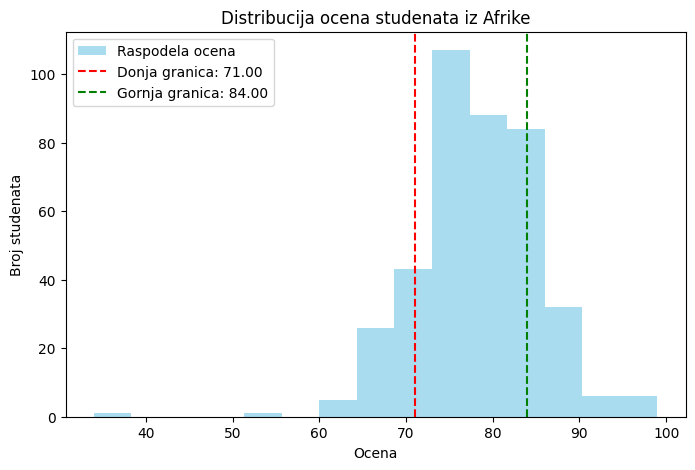

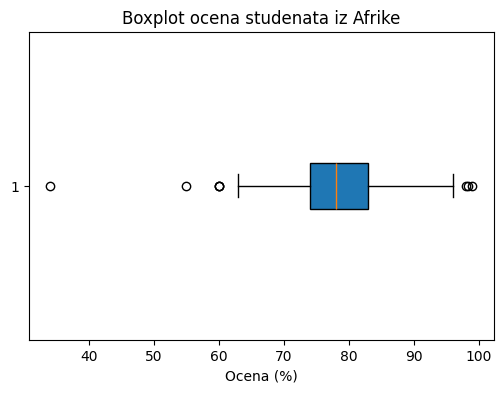

In [16]:
#transformacija africkog data set-a
transformed_af_data = transform_african_data(af_data)

Vrši transformacija sirovih podataka za afričke studente u standardizovani oblik.  
Primene se sledeće transformacije:
- Pol (`pol`) se mapira **M**
- Godina studija (`godina_studija`) se prevodi u numeričke vrednosti (1–4)
- Ocene (`ocena`) se analiziraju, uklanjaju se autlajeri i pravi se histogram distribucije sa prikazanim granicama
- Društvene aktivnosti se prevode u broj sati učenja nedeljno
- Prisustvo se klasifikuje na osnovu izostanaka zbog alkohola
- Status smeštaja, finansije i veze sa roditeljima se mapiraju u standardizovan oblik
- Polje `u_vezi` označava da li je student trenutno u romantičn
oGa kraju, gehistograme grafikon raspodele ocena kako bi se vizuelno prikazale granice i kate i boxplot za prikaz ocena outlier-a 
Analizom grafikona ustanovljeno je da se bolje granice utvrđuju uzimanjem manjih percentila (41 umesto 25 i 61 umesto 75, odnosno klasicne raspodele), odnosno uklanjanjem outlier-aorizacija.

In [17]:
def transform_iraqi_data(df):
    transformed = pd.DataFrame(columns=required_columns)

    transformed['pol'] = df['Sex'].apply(lambda x: 'F' if str(x).strip().lower() == 'female' else 'M')

    transformed['godina_studija'] = df['Age']

    specialization_mapping = {
        'BIO': 'Biology',
        'APP': 'Engineering'
    }
    transformed['oblast'] = df['Specialization'].map(specialization_mapping)

    transformed['drzava'] = 'Iraq'

    df['Avg'] = (df['Avg1'] + df['Avg2']) / 2
    grades = df['Avg'].astype(float)
    lower_bound, upper_bound = remove_outliers_and_determine_bounds(grades)
    
    plt.figure(figsize=(6,4))
    plt.boxplot(grades, vert=False, patch_artist=True)
    plt.title("Boxplot distribucije ocena iračkih studenata")
    plt.xlabel("Prosek (Avg1 + Avg2)/2")
    plt.show()
    
    plot_grade_distribution_and_boundaries(grades, 'Distribucija ocena studenata iz Iraka',lower_bound+5, upper_bound-5)

    transformed['ocena'] = categorize_grades(grades, lower_bound, upper_bound)

    transformed['sati_ucenja_nedeljno'] = df['Study Hour']

    transformed['prisustvo_na_nastavi'] = df['Attendance']

    transformed['smestaj'] = df['Home Ownership'].apply(lambda x: 'Private' if x.strip().lower() == 'own' else 'Non private')

    transformed['finansijski_status'] = df['Family Economic Level']

    family_relationship_mapping = {
        'good': 'Close',
        'excellent': 'Very close',
        'vgood': 'Very close',
        'sobad': 'Fair',
        'bad': 'Fair'
    }
    transformed['bliskost_sa_roditeljima'] = df['Family Relationship'].map(family_relationship_mapping)

    parent_educational_mapping = {
        'secondary': 2,
        'higher': 4,
        'medium': 3,
        'ba': 5,
    }
    transformed['edukacija_roditelja'] = df['Father education'].map(parent_educational_mapping).fillna(1).astype(int)

    transformed['u_vezi'] = df['Social Status'].apply(lambda x: 'no' if x.strip().lower() == 'single' else 'yes')

    return transformed

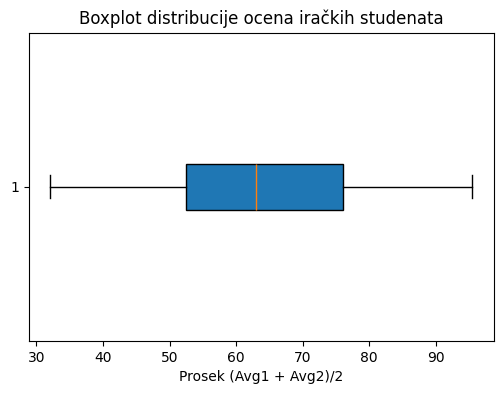

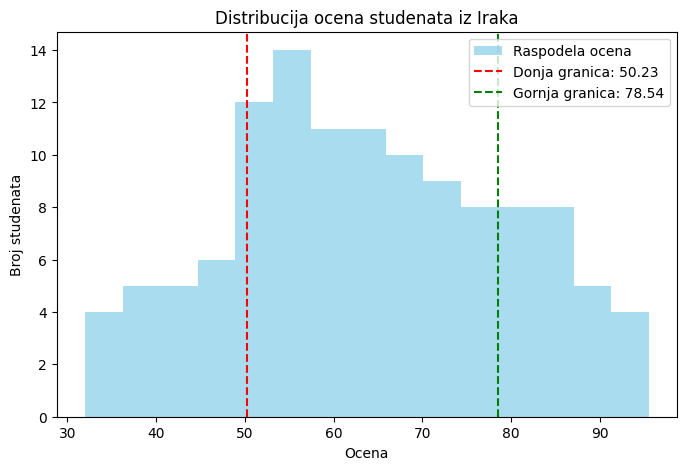

In [18]:
#transformacija irackog data set-a
transformed_ir_data = transform_iraqi_data(ir_data)

Vršimo transformaciju podataka iz iračkog dataset-a.

Kolona Sex se prevodi u oznake pola (M/F).
Godina studija se aproksimira direktno na osnovu Age vrednosti.
Polje Specialization se mapira na oblast studija (Biology ili Engineering).
Kreiramo novu kolonu Avg kao prosek vrednosti Avg1 i Avg2, što nam daje realniju sliku uspeha studenta.
Na osnovu raspodele ocena vršimo detekciju i eliminaciju outliera pomoću IQR metode i kategorizaciju u grupe A, B, C.
Prisustvo, finansijski status i smeštaj direktno se mapiraju iz originalnih kolona.
Porodični odnosi i edukacija roditelja se standardizuju kroz unapred definisane mape.
Na kraju dodajemo i podatak da li je student u vezi ili ne.

Za analizu ocena koristimo boxplot, jer jasno pokazuje raspon vrednosti, medijanu i outliere. Time se vizuelno potvrđuje opravdanost naše obrade ocena.

In [19]:
def transform_portugal_data(df):
    transformed = pd.DataFrame(columns=required_columns)

    transformed['pol'] = df['sex']

    year_mapping = {
        15: 1,
        16: 2,
        17: 3,
        18: 4
    }

    transformed['godina_studija'] = df['age'].map(year_mapping)

    transformed['oblast'] = 'Engineering'

    transformed['drzava'] = 'Portugal'

    grades = df['G3'].astype(float)
    lower_bound, upper_bound = remove_outliers_and_determine_bounds(grades)

    plt.figure(figsize=(6,4))
    plt.boxplot(grades, vert=False, patch_artist=True)
    plt.title("Boxplot završnih ocena studenata iz Portugala (G3)")
    plt.xlabel("Ocene")
    plt.show()

    plot_grade_distribution_and_boundaries(grades, 'Distribucija ocena studenata iz Portugala', lower_bound-1, upper_bound+1)
    transformed['ocena'] = categorize_grades(grades, lower_bound, upper_bound)

    transformed['sati_ucenja_nedeljno'] = df['studytime']

    transformed['prisustvo_na_nastavi'] = df['absences'].apply(classify_portugal_presence)

    transformed['smestaj'] = df['schoolsup'].apply(lambda x: 'Private' if x.strip() == 'no' else 'Non private')

    transformed['finansijski_status'] = df['internet'].apply(lambda x: 'poor' if x.strip() == 'no' else 'good')

    family_relationship_mapping = {
        5: 'Very close',
        4: 'Very close',
        3: 'Close',
        2: 'Close',
        1: 'Fair'
    }
    transformed['bliskost_sa_roditeljima'] = df['famrel'].map(family_relationship_mapping)

    transformed['edukacija_roditelja'] = df['Fedu']

    transformed['u_vezi'] = df['romantic']

    return transformed

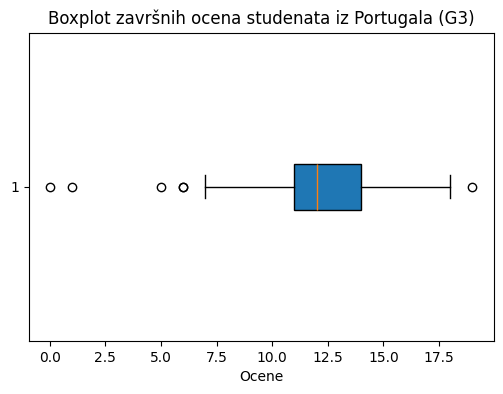

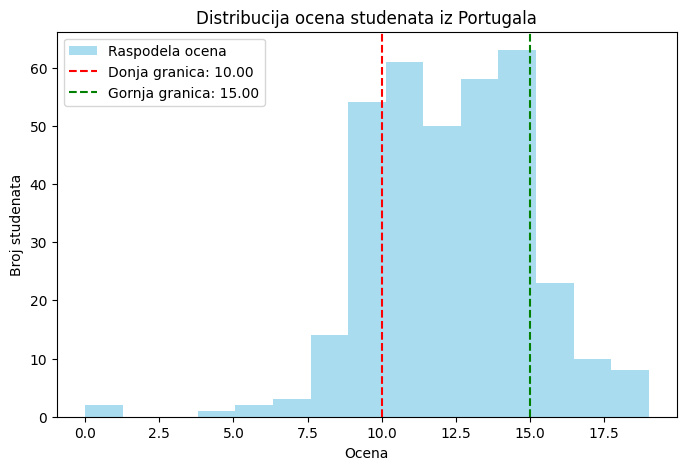

In [20]:
#transformacija portugalskog data set-a
transformed_pr_data = transform_portugal_data(pr_data)

Vršimo transformaciju podataka iz portugalskog dataset-a.

Kolona sex se direktno koristi kao oznaka pola (M/F).
Godina studija se aproksimira mapiranjem iz age vrednosti (15 → 1. godina, 16 → 2. godina itd.).
Polje oblast se postavlja na "Engineering", jer svi studenti pripadaju toj oblasti.
Kreiramo kolonu drzava sa vrednošću "Portugal".
Ocene se preuzimaju iz kolone G3 (završna ocena). Nad njima se vrši detekcija i eliminacija outliera pomoću modifikovane IQR metode, a zatim kategorizacija u grupe uspeha (A, B, C).
Broj sati učenja nedeljno dolazi iz kolone studytime.
Prisustvo se računa na osnovu absences, koje se dalje klasifikuju u kategorije (niska, srednja, visoka).
Tip smeštaja se određuje na osnovu kolone schoolsup: studenti bez dodatne podrške se tretiraju kao privatni smeštaj, a ostali kao neprivatni.
Finansijski status se procenjuje prema koloni internet (studenti bez interneta su označeni kao "poor", a sa internetom kao "good").
Bliskost sa roditeljima se standardizuje mapiranjem vrednosti iz kolone famrel u opisne kategorije ("Very close", "Close", "Fair").
Edukacija roditelja se preuzima direktno iz kolone Fedu.
Polje u_vezi se formira na osnovu vrednosti kolone romantic.

Za analizu ocena koristimo histogram i boxplot. Histogram omogućava uvid u distribuciju završnih ocena, dok boxplot jasno pokazuje medijanu, kvartile i outliere. Na ovaj način vizuelno potvrđujemo opravdanost čišćenja podataka i kategorizacije uspeha.

In [21]:
def transform_pakistani_data(df):
    transformed = pd.DataFrame(columns=required_columns)

    transformed['pol'] = df['Gender']

    transformed['godina_studija'] = df['Age'].apply(pakistani_year_of_study_mapping)

    transformed['oblast'] = df['Major']
    transformed['drzava'] = 'Pakistan'
    
    transformed['ocena'] = df['Grades']

    transformed['sati_ucenja_nedeljno'] = df['Study_Hours'].apply(lambda x: int(x/5) if pd.notna(x) else '')
    boundaries_attendance = categorize_attendance(pk_data, "Attendance")

    def attendance_quality(value):
        if pd.isna(value):
            return ''
        try:
            value = float(value)
            if value > boundaries_attendance[1]:
                return 'vgood'
            elif boundaries_attendance[0] <= value <= boundaries_attendance[1]:
                return 'good'
            else:
                return 'poor'
        except ValueError:
            return ''

    transformed['prisustvo_na_nastavi'] = df['Attendance'].apply(attendance_quality)

    transformed['smestaj'] = df['Study_Space'].apply(
        lambda x: 'Private' if str(x).strip().lower() == 'yes' else ('Non private' if str(x).strip().lower() == 'no' else ''))

    financial_mapping = {
        'Low': 'poor',
        'Medium': 'good',
        'High': 'vgood'
    }
    transformed['finansijski_status'] = df['Financial_Status'].apply(
        lambda x: financial_mapping.get(str(x).strip(), '') if pd.notna(x) else 'good'
    )

    parental_mapping = {
        'Low': 'Fair',
        'Medium': 'Close',
        'High': 'Very close'
    }
    transformed['bliskost_sa_roditeljima'] = df['Parental_Involvement'].apply(
        lambda x: parental_mapping.get(str(x).strip(), '') if pd.notna(x) else 'Close'
    )

    transformed['edukacija_roditelja'] = df['Parental_Education'].apply(
        lambda x: map_pakistani_parent_education(x))

    transformed['u_vezi'] = ''

    return transformed

Vršimo transformaciju podataka iz pakistanskog dataset-a.

Kolona Gender se direktno koristi kao oznaka pola (M/F).
Godina studija se računa transformacijom na osnovu Age, pomoću funkcije pakistani_year_of_study_mapping.
Polje oblast se preuzima iz kolone Major, a kolona drzava se postavlja na "Pakistan".
Ocene se preuzimaju iz kolone Grades bez dodatne transformacije.
Broj sati učenja nedeljno se računa iz kolone Study_Hours, deljenjem sa 5 (pretpostavka: konverzija ukupnih sati u prosek nedeljno).
Prisustvo na nastavi se kategorizuje na osnovu vrednosti iz kolone Attendance, u poređenju sa preračunatim granicama (poor, good, vgood).
Tip smeštaja se određuje na osnovu Study_Space (yes → Private, no → Non private).
Finansijski status se standardizuje preko Financial_Status, mapiranjem vrednosti (Low → poor, Medium → good, High → vgood).
Bliskost sa roditeljima se preuzima iz Parental_Involvement, gde se vrednosti mapiraju u opisne kategorije ("Fair", "Close", "Very close").
Edukacija roditelja se računa posebnom funkcijom map_pakistani_parent_education.
Kolona u_vezi se ostavlja prazna jer dataset ne sadrži te podatke.


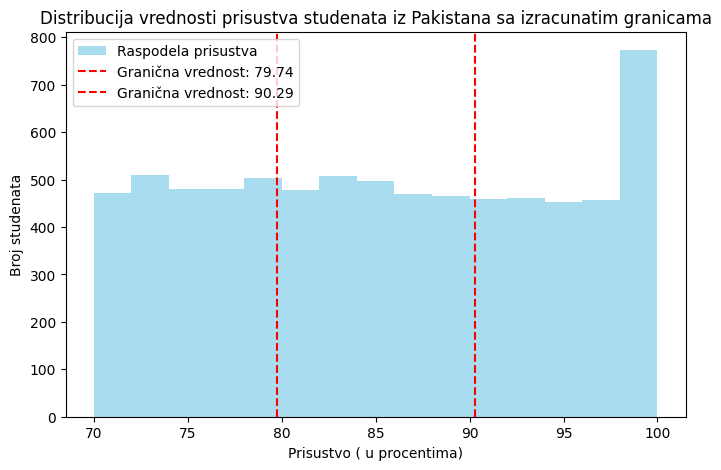

In [22]:
transformed_pk_data = transform_pakistani_data(pk_data)
#usled lošije tacnosti sa velikim uzorkom pakistanskog dataseta, smanjen je uzorak koji je dalje koristi 
#(Takođe i na osnovu zakljucka iz drugih radova koji su koristili ovaj dataset koji su istu imali manju tacnost)
transformed_pk_data = transformed_pk_data.sample(n=100, random_state=42)


In [23]:
#spajanje data set-ova
empty_dataset = pd.concat([transformed_af_data, transformed_ir_data, transformed_pr_data, transformed_pk_data], ignore_index=True)
empty_dataset = empty_dataset.dropna(subset=['ocena','pol','godina_studija','oblast','smestaj','bliskost_sa_roditeljima'])
empty_dataset['sati_ucenja_nedeljno'] = pd.to_numeric(empty_dataset['sati_ucenja_nedeljno'], errors='coerce')
# Kvadratna interpolacija i zaokruživanje
empty_dataset['sati_ucenja_nedeljno'] = (
    empty_dataset['sati_ucenja_nedeljno']
    .interpolate(method='quadratic')
    .round(1)
)

status_mapping = {'poor': 0, 'good': 1, 'vgood': 2}
empty_dataset['finansijski_status_numeric'] = empty_dataset['finansijski_status'].map(status_mapping)

empty_dataset['finansijski_status_numeric'] = empty_dataset['finansijski_status_numeric'].interpolate(method='quadratic')

reverse_mapping = {v: k for k, v in status_mapping.items()}
empty_dataset['finansijski_status'] = empty_dataset['finansijski_status_numeric'].round().astype(int).map(reverse_mapping)

empty_dataset = empty_dataset.drop(columns=['finansijski_status_numeric'])
empty_dataset.to_csv('datasets/Afr-Ir-Por-Pak.csv', index=False)


Spajamo transformisane dataset-e za sve četiri države u jedan zajednički dataset empty_dataset koji koristimo dalje za predikciju ocene.
Uklanjamo redove za koje nemamo poznate vrednosti i tesko ih mozemo interpolirati ili uzeti za njih neku predviđenu vrednost (ocena, pol, godina_studija, oblast, smestaj, bliskost_sa_roditeljima).
Konvertujemo kolonu sati_ucenja_nedeljno u numerički tip kako bismo mogli primeniti interpolaciju.
Mapiramo tekstualne kategorije (poor, good, vgood) u numeričke vrednosti, interpoliramo praznine, a zatim vraćamo nazad u kategorije.
Time se uklanjaju nedostajuće vrednosti i omogućava dosledna analiza.
Kasnijom analizom tacnosti modela ustanovljeno je da se bolji rezultati dobiju ako se kolona finansijski status ne uzima u razmatranje pa je izbacena.
Ovim pristupom očuvamo logičan trend u podacima i omogućavamo preciznije statističke analize i dalje predikcije ocena.


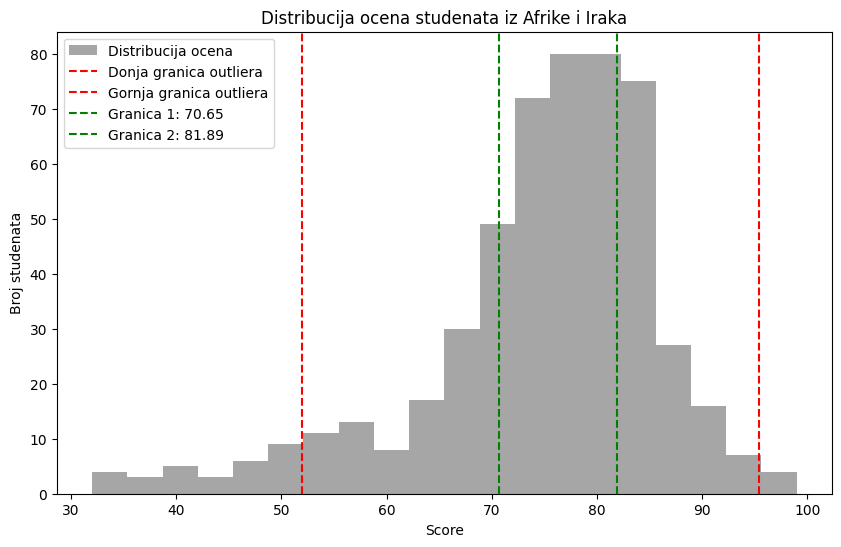

In [24]:
def calculate_combined_boundaries(africa_grades, iraq_avg_grades):
    all_grades = np.concatenate([africa_grades, iraq_avg_grades])
    all_grades = all_grades[~np.isnan(all_grades)]

    mean = np.mean(all_grades)
    std_dev = np.std(all_grades)

    lower_bound_outliers = mean - 2 * std_dev
    upper_bound_outliers = np.percentile(all_grades, 99)  

    filtered_grades = all_grades[(all_grades >= lower_bound_outliers) & (all_grades <= upper_bound_outliers)]

    kmeans = KMeans(n_clusters=3, random_state=42).fit(filtered_grades.reshape(-1, 1))
    centers = sorted(kmeans.cluster_centers_.flatten())

    upper_boundary = (centers[1] + centers[2]) / 2 + 3  # Postavljanje gornje granice između drugog i trećeg centra
    boundaries = [min(filtered_grades), (centers[0] + centers[1]) / 2 + 3, upper_boundary, max(filtered_grades)]
    
    plt.figure(figsize=(10, 6))
    plt.hist(all_grades, bins=20, color='gray', alpha=0.7, label="Distribucija ocena")
    
    plt.axvline(lower_bound_outliers, color='red', linestyle='--', label='Donja granica outliera')
    plt.axvline(upper_bound_outliers, color='red', linestyle='--', label='Gornja granica outliera')
    plt.axvline(boundaries[1], color='green', linestyle='--', label=f'Granica 1: {boundaries[1]:.2f}')
    plt.axvline(boundaries[2], color='green', linestyle='--', label=f'Granica 2: {boundaries[2]:.2f}')

    plt.title("Distribucija ocena studenata iz Afrike i Iraka")
    plt.xlabel("Score")
    plt.ylabel("Broj studenata")
    plt.legend(loc='upper left')

    plt.show()

af_data = pd.read_csv('datasets/afrika.csv')
ir_data = pd.read_csv('datasets/irak.csv')
af_data = af_data.dropna(subset=['Your Matric (grade 12) Average/ GPA (in %)'])
ir_data = ir_data.dropna(subset=['Avg1', 'Avg2'])

africa_grades = af_data['Your Matric (grade 12) Average/ GPA (in %)']
iraq_avg_grades = ((ir_data['Avg1'] + ir_data['Avg2']) / 2)

calculate_combined_boundaries(africa_grades, iraq_avg_grades)

- Kombinovane su ocene studenata iz Afrike i Iraka u jednu listu kao dve najvece grupe studenata koje razmatramo

- Izračunati su prosek i standardna devijacija svih ocena.

- Postavljene su granice outliera: donja = mean - 2*std_dev, gornja = 99. percentil.

- Ocene koje nisu outlieri su korišćene za KMeans klasterovanje u 3 grupe (3 grupe uspesnosti studenata ) - kako bismo oderdili centre grupa (prosecne - ocene za svaku grupu i lakse kasnije poredili tacnost dobijene procene uspeha )

- Dobijeni centri klastera su sortirani i korišćeni za izračunavanje graničnih vrednosti između klastera.

- Vizuelno se na histogramu vidi raspodela ocena, identifikacija outliera i podela na grupe prema uspehu.

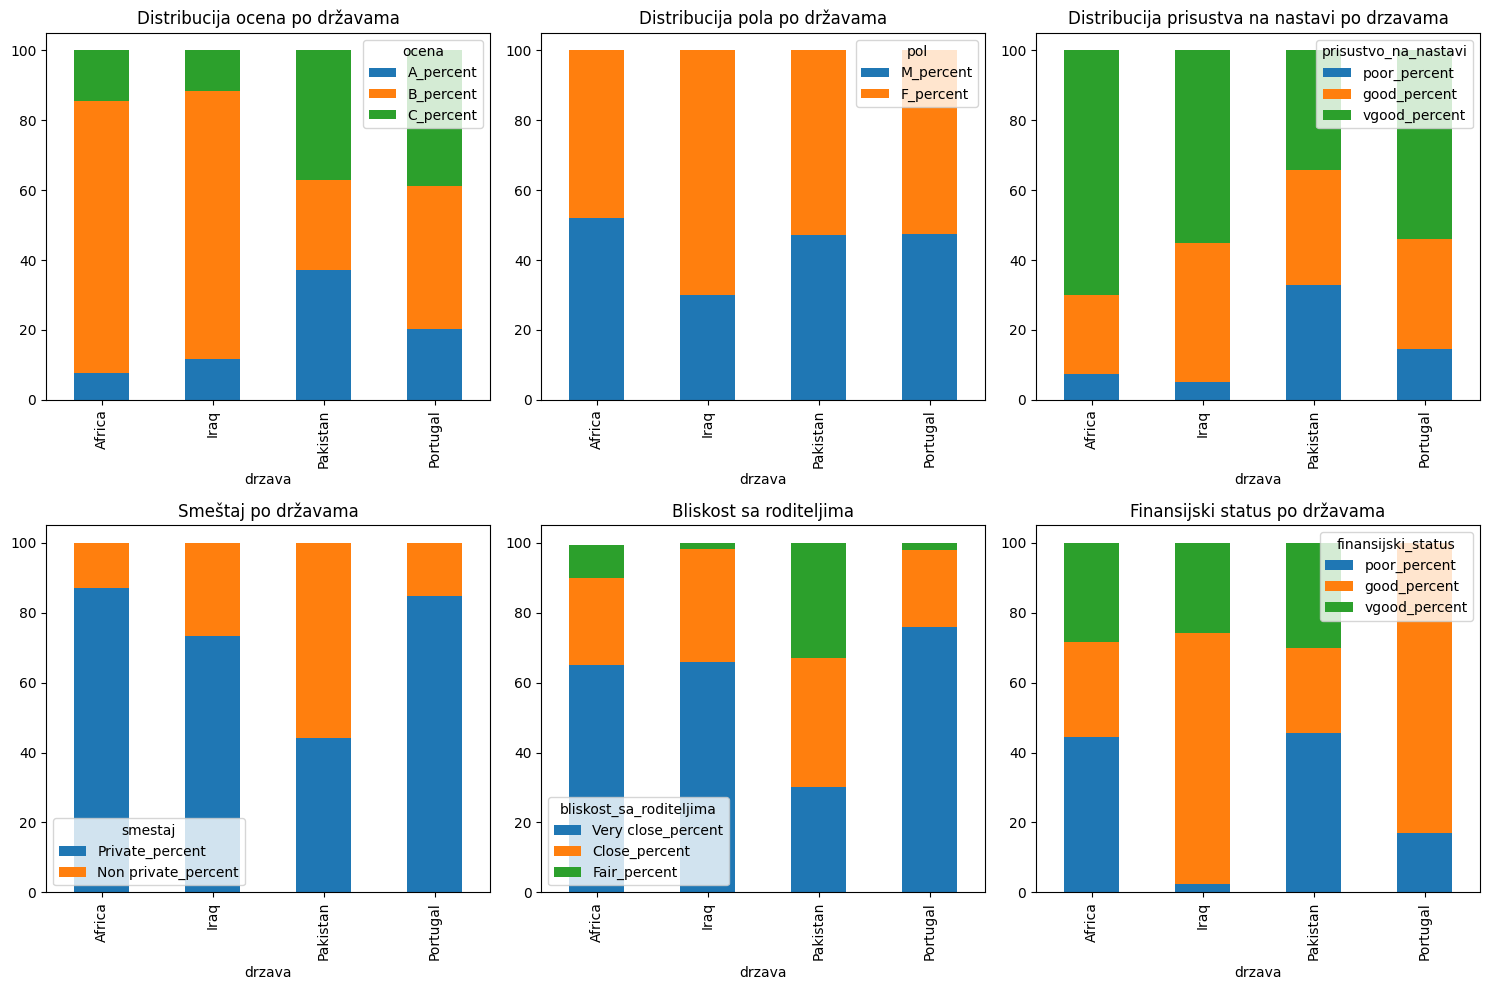


Prosečna količina učenja na skali 1-4 po državama:
drzava
Africa      2.094118
Iraq        2.008333
Pakistan    2.014286
Portugal    1.982301
Name: sati_ucenja_nedeljno, dtype: float64


In [25]:
def calculate_percentages(df, column):
    counts = df.groupby(['drzava', column]).size().unstack(fill_value=0)
    counts['Total'] = counts.sum(axis=1)
    for value in counts.columns[:-1]:  
        counts[f'{value}_percent'] = (counts[value] / counts['Total']) * 100
    return counts

ocena_vrednosti = {'A': 3, 'B': 2, 'C': 1}

ocena_counts = calculate_percentages(empty_dataset, 'ocena')
ocena_counts['Prosecna_uspesnost'] = (
    ocena_counts['A'] * ocena_vrednosti['A'] +
    ocena_counts['B'] * ocena_vrednosti['B'] +
    ocena_counts['C'] * ocena_vrednosti['C']
) / ocena_counts['Total']

najuspesnija_drzava = ocena_counts['Prosecna_uspesnost'].idxmax()
najmanje_uspesna_drzava = ocena_counts['Prosecna_uspesnost'].idxmin()

pol_counts = calculate_percentages(empty_dataset, 'pol')
prisustvo_counts = calculate_percentages(empty_dataset, 'prisustvo_na_nastavi')
smestaj_counts = calculate_percentages(empty_dataset, 'smestaj')
bliskost_counts = calculate_percentages(empty_dataset, 'bliskost_sa_roditeljima')
finansije_counts = calculate_percentages(empty_dataset, 'finansijski_status')

sati_ucenja = empty_dataset.groupby('drzava')['sati_ucenja_nedeljno'].mean()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ocena_counts[['A_percent', 'B_percent', 'C_percent']].plot(kind='bar', stacked=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribucija ocena po državama')

pol_counts[['M_percent', 'F_percent']].plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribucija pola po državama')

prisustvo_counts[["poor_percent","good_percent","vgood_percent"]].plot(kind='bar',stacked=True, ax=axes[0,2])
axes[0,2].set_title('Distribucija prisustva na nastavi po drzavama')



smestaj_counts[['Private_percent', 'Non private_percent']].plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title('Smeštaj po državama')

bliskost_counts[['Very close_percent', 'Close_percent', 'Fair_percent']].plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_title('Bliskost sa roditeljima')

finansije_counts[['poor_percent', 'good_percent', 'vgood_percent']].plot(kind='bar', stacked=True, ax=axes[1, 2])
axes[1, 2].set_title('Finansijski status po državama')

plt.tight_layout()
plt.show()


print("\nProsečna količina učenja na skali 1-4 po državama:")
print(sati_ucenja)

### Analiza distribucija i uspešnosti učenika

Na grafikonima iznad prikazali smo različite karakteristike učenika po državama:  

**Cilj prikaza** je da se dobiju uvidi u faktore koji mogu uticati na školsku uspešnost učenika i da se uporede razlike među državama.

Iz prikaza vidimo:  
- Najuspešnija država je **Iraq** sa prosečnom uspešnošću 2.00, dok je najmanje uspešna **Portugal** sa 1.81.  
- Najveći procenat učenika u Iraku pripada višim kategorijama uspeha (ocena A i B), dok u Portugalu dominira niži nivo uspeha.  
- Distribucija prisustva na nastavi pokazuje jasnu vezu sa rezultatima – države sa većim prisustvom (npr. Iraq i Pakistan) imaju i višu prosečnu uspešnost.  
- Finansijski status i tip smeštaja se razlikuju među državama, što može biti značajan faktor za obrazovna postignuća.  
- Bliskost sa roditeljima takođe se pokazuje kao važan element – u državama gde dominira „Very close“ kategorija, beleži se i bolja uspešnost.  

**Zaključak:**  
Ova analiza nam omogućava da povežemo više socijalnih i ekonomskih faktora sa školskim uspehom. Time se stiče šira slika o tome zašto su neke države uspešnije, a neke manje uspešne u proseku.



In [80]:
#Klasifikacija studenata 
data = empty_dataset
data = data.replace('', np.nan)

full_data = data.dropna(subset=['ocena'])  
full_data = full_data.dropna()             

X = full_data.drop(columns=['ocena'])
y = full_data['ocena']


feature_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = feature_encoder.fit_transform(X[column])

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_valid=scaler.transform(X_valid)

print('Treniranje modela za predikciju ocena studenata...\n')

Treniranje modela za predikciju ocena studenata...



C:\Users\Admin\AppData\Local\Temp\ipykernel_14828\2716666665.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace('', np.nan)


U ovoj fazi vršimo obradu i pripremu skupa podataka:

- zamenjujemo prazne vrednosti sa NaN,

- razdvajamo ulazne i izlazne promenljive (X i y),

- kategorijske podatke pretvaramo u numeričke vrednosti (LabelEncoder),

- delimo podatke na trening, validacioni i test skup,

- vršimo standardizaciju podataka (StandardScaler).

Ovim korakom podaci postaju pogodni za treniranje modela mašinskog učenja koji će predviđati ocenu studenata na osnovu dostupnih atributa.

In [115]:
# KNN Model
knn_model = KNeighborsClassifier(
    algorithm = 'auto',
    leaf_size = 15,
    metric = 'minkowski',
    n_neighbors = 15,
    p = 2,
    weights = 'uniform'
)

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_valid)
knn_accuracy = accuracy_score(y_valid, y_pred_knn)
print(f"Tačnost k-NN modela: {knn_accuracy:.4f}")

y_pred_knn_test = knn_model.predict(X_test)
knn_test_accuracy = accuracy_score(y_test, y_pred_knn_test)
print(f"Tačnost k-NN modela na test skupu: {knn_test_accuracy:.4f}")

Tačnost k-NN modela: 0.5676
Tačnost k-NN modela na test skupu: 0.6087


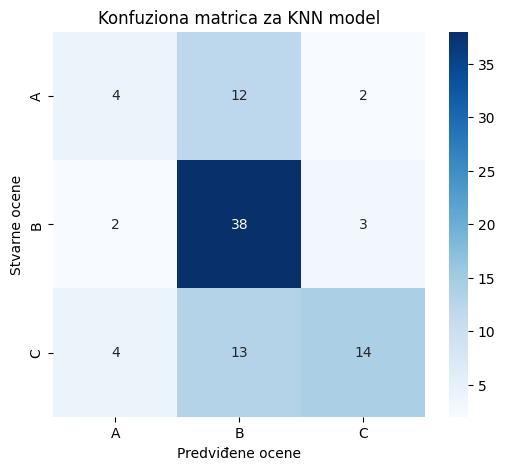

In [116]:
cm = confusion_matrix(y_test, y_pred_knn_test)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.xlabel("Predviđene ocene")
plt.ylabel("Stvarne ocene")
plt.title("Konfuziona matrica za KNN model")
plt.show()

Za klasifikaciju studenata korišćen je KNN algoritam, koji predviđa ocenu studenta na osnovu sličnosti sa drugim studentima.

Parametri modela:

- broj suseda = 23,

- metrika udaljenosti = Manhattan distanca,

- svi susedi imaju jednak uticaj.

Model je prvo evaluiran na validacionom skupu, a zatim i na test skupu.
Dobijene vrednosti tačnosti pokazuju koliko dobro model može da generalizuje na nove podatke.

In [ ]:
#Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    min_samples_split=5,
    min_samples_leaf=10,
)

# Treniranje na trening skupu
rf.fit(X_train, y_train)

# Validacija na validacionom skupu
y_valid_pred = rf.predict(X_valid)
valid_acc = accuracy_score(y_valid, y_valid_pred)
print("Validation Accuracy (RF):", valid_acc)

# Treniranje na trening + validacionom skupu
X_train_full = np.vstack([X_train, X_valid])
y_train_full = np.hstack([y_train, y_valid])
rf.fit(X_train_full, y_train_full)

# Testiranje na test skupu
y_test_pred = rf.predict(X_test)
rf_test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy (RF):", rf_test_acc)


print('\nPrikaz koji atributi su najvažniji za predviđanje:')
feature_names = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for idx in indices:
    print(f"Feature '{feature_names[idx]}': {importances[idx]}")


Validation Accuracy (RF): 0.6756756756756757
Test Accuracy (RF): 0.5434782608695652

Prikaz koji atributi su najvažniji za predviđanje:
Feature 'drzava': 0.22506911775477884
Feature 'edukacija_roditelja': 0.13407126807914113
Feature 'prisustvo_na_nastavi': 0.11139034204908291
Feature 'sati_ucenja_nedeljno': 0.10991269615231315
Feature 'oblast': 0.0990056213441433
Feature 'pol': 0.09256492918201543
Feature 'godina_studija': 0.06911546035727303
Feature 'smestaj': 0.051683789445630235
Feature 'finansijski_status': 0.04264096369013389
Feature 'u_vezi': 0.035923127884473716
Feature 'bliskost_sa_roditeljima': 0.028622684061014265


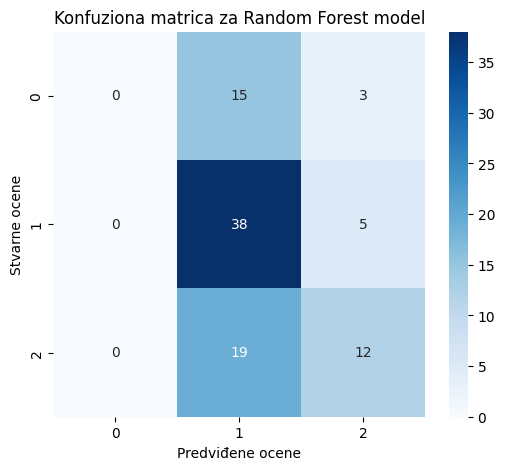

In [118]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))
plt.xlabel("Predviđene ocene")
plt.ylabel("Stvarne ocene")
plt.title("Konfuziona matrica za Random Forest model")
plt.show()

Random Forest klasifikacija 

- Kreiran **Random Forest** klasifikator sa:
  - broj stabala - 100 
  - maksimalna dubina stabala - 5
  - kontrola overfitting-a - `min_samples_split=5` i `min_samples_leaf=10` 

- Prikazana **važnost atributa** kako bi se videlo koji atributi najviše doprinose predikciji.


In [ ]:
#MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=1500,
    activation='relu',
    solver='sgd',
    random_state=42,
    learning_rate_init=0.001,
    alpha=0.01,
    early_stopping=False
)
# Treniranje na test skupu
mlp.fit(X_train, y_train)

# Evaluacija na validacionom skupu
y_valid_pred = mlp.predict(X_valid)
valid_acc = accuracy_score(y_valid, y_valid_pred)
print("Validation Accuracy:", valid_acc)

# Treniranje na celom trening skupu (train + valid)
X_train_full = np.vstack([X_train, X_valid])
y_train_full = np.hstack([y_train, y_valid])
mlp.fit(X_train_full, y_train_full)

# Testiranje na test skupu
y_test_pred = mlp.predict(X_test)
mpl_test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", mpl_test_acc)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation Accuracy: 0.6216216216216216
Test Accuracy: 0.5652173913043478


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


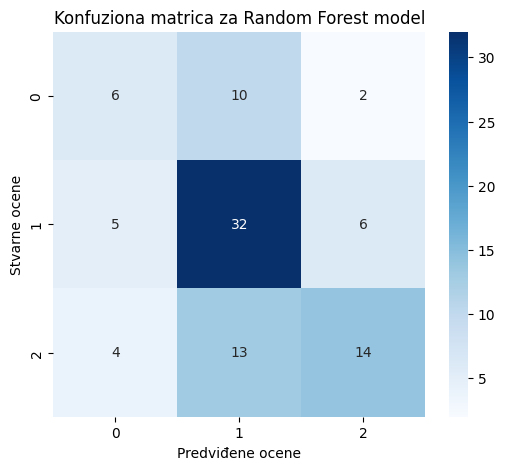

In [120]:
cm = confusion_matrix(y_test, y_test_pred) 

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),  
            yticklabels=np.unique(y_test))
plt.xlabel("Predviđene ocene")
plt.ylabel("Stvarne ocene")
plt.title("Konfuziona matrica za Random Forest model")
plt.show()

- Kreiran **MLP (Multi-Layer Perceptron)** klasifikator sa:
  - 4 skrivena sloja po 32 neurona `(32, 32, 32, 32)`
  - Aktivacija: `ReLU`
  - Optimizer: `Adam`
  - Maksimalno iteracija: `3000`
  - Inicijalna stopa učenja: `0.001`
  - Regularizacija: `alpha=0.0001`
  - `early_stopping=True` i `n_iter_no_change=15` (za zaustavljanje treniranja kad nema poboljšanja)

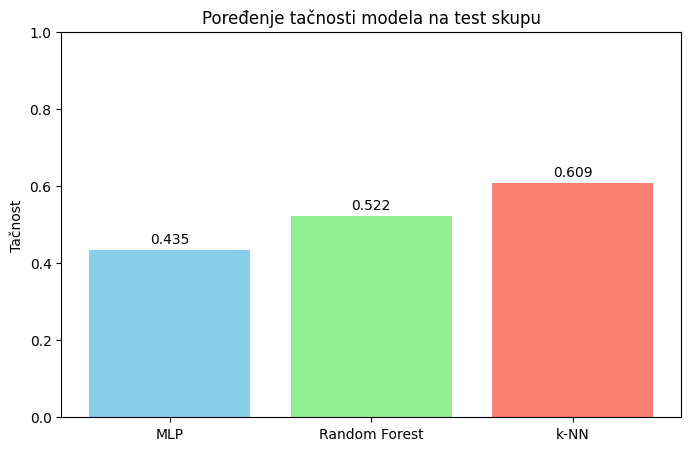

In [ ]:
models = ['MLP', 'Random Forest', 'k-NN']
accuracies = [mpl_test_acc, rf_test_acc, knn_test_accuracy]

plt.figure(figsize=(8,5))
bars = plt.bar(models, accuracies, color=['skyblue','lightgreen','salmon'])
plt.ylim(0,1)
plt.ylabel('Tačnost')
plt.title('Poređenje tačnosti modela na test skupu')

# Prikaz vrednosti na vrhu barova bez zaokruživanja
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

plt.show()

Na osnovu bar grafikona vidimo da smo najvecu tacnost postigli sa KNN modelom.

In [122]:
student_columns = [
    'pol',
    'godina_studija',
    'oblast',
    'drzava',
    'kolicina_ucenja',
    'prisustvo_na_nastavi',
    'smestaj',
    'finansijski_status',
    'bliskost_sa_roditeljima'
]

X_new = [[
      'M',          #pol
      3,            #godina
      'Arts',       #oblast
      'Portugal',   #drzava
      2,            #sati ucenja (bolje reci kolicina ucenja na skali 1-4)
      'vgood',      #prisustvo na nastavi
      'Private',    #smestaj
      'vgood',      #finansije
      'Very close'  #odnos sa roditeljima
]]

print("\n--------------------------------------------")
print("Primer podataka jednog studenta:")
for col, val in zip(student_columns, X_new[0]):
    print(f"{col}: {val};")
    
X_new_df = pd.DataFrame(0, index=[0], columns=X.columns)

# Popuni kolone koje znaš za novog studenta
X_new_df['pol'] = feature_encoder.fit_transform(['M'])[0] 
X_new_df['godina_studija'] = 3
X_new_df['oblast'] = feature_encoder.fit_transform(['Arts'])[0]
X_new_df['drzava'] = feature_encoder.fit_transform(['Portugal'])[0]
X_new_df['sati_ucenja_nedeljno'] = 2  # umesto kolicina_ucenja
X_new_df['prisustvo_na_nastavi'] = feature_encoder.fit_transform(['vgood'])[0]
X_new_df['smestaj'] = feature_encoder.fit_transform(['Private'])[0]
X_new_df['finansijski_status'] = feature_encoder.fit_transform(['vgood'])[0]
X_new_df['bliskost_sa_roditeljima'] = feature_encoder.fit_transform(['Very close'])[0]

X_new_scaled = scaler.transform(X_new_df)

# Predikcija sa svim modelima
pred_mlp = mlp.predict(X_new_scaled)
pred_rf = rf.predict(X_new_scaled)
pred_knn = knn_model.predict(X_new_scaled)

label_mlp = target_encoder.inverse_transform(pred_mlp)
label_rf = target_encoder.inverse_transform(pred_rf)
label_knn = target_encoder.inverse_transform(pred_knn)

print("\nPredikcije za novog studenta:")
print("MLP:", label_mlp[0])
print("Random Forest:", label_rf[0])
print("KNN:", label_knn[0])


--------------------------------------------
Primer podataka jednog studenta:
pol: M;
godina_studija: 3;
oblast: Arts;
drzava: Portugal;
kolicina_ucenja: 2;
prisustvo_na_nastavi: vgood;
smestaj: Private;
finansijski_status: vgood;
bliskost_sa_roditeljima: Very close;

Predikcije za novog studenta:
MLP: B
Random Forest: B
KNN: B


**Primer predikcije za novog studenta**
- Na osnovu odabranih atributa, modeli procenjuju da student ima solidan nivo uspeha (ocena B).

- Rezultat takođe ukazuje da je kombinacija faktora kao što su prisustvo, količina učenja i finansijski/status porodičnih odnosa važna za predikciju ocena
